In [1]:
# import libraries
import numpy as np
import pandas as pd
import os, h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
from codes import jason_plotting as plotting
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('/Users/jasonwu/Programs/codes/def.mplstyle')
plotting.plot_prettier(dpi=400,usetex=False)
%matplotlib inline


Bad key grid.zorder in file /Users/jasonwu/Programs/codes/def.mplstyle, line 19 ('grid.zorder : 2.5')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.1/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
labels_keys = 'electron neutron photon pion proton'.split(' ')
labels_values = [r'Electrons $e^{\minus}$', r'Neutrons $n^{o}$', r'Photons $\gamma$', r'Pions $\pi^{\minus}$', r'Protons $p^{\plus}$']

labels_dict = {labels_keys[i]: labels_values[i] for i in range(len(labels_keys))}

In [18]:
# initiate a particle class
class Particles():
    def __init__(self, hf):
        # a list of properties
        self.propdict = {}
        # initiate all properties
        for prop in hf.keys():
            # convert to numpy array
            self.propdict[prop] = hf[prop][()]
        self._clean_props()
    
    # clean the data set
    def _clean_props(self):
        for prop in list(self.propdict.keys()):
            nan_bool_mask = np.isnan(self.propdict[prop])
            if np.any(nan_bool_mask):
#                 print(f'{np.sum(nan_bool_mask):<10} NaN values for {prop}')
                self.propdict[prop] = self.propdict[prop][~np.isnan(self.propdict[prop])]
                
#         print('\n')
    
    # return a property
    def get(self, prop = None):
        if prop is not None:  # if specific property(ies) are given
            if isinstance(prop, list):
                prop_list = []
                for single_prop in prop:
                    prop_list.append(self.propdict[single_prop])
                return prop_list
            else:
                assert prop in list(self.propdict.keys())
                return self.propdict[prop]
        else:
            return self.propdict
    
    # return a list of all properties
    def list_props(self):        
        print(f'{"Property Name":<30}{"Number of Entries":<20}{"Unique Entries":<20}{"Range":<30}{"Mean"}')
        
        for prop in list(self.propdict.keys()):
            print(f'{prop: <30}{len(self.propdict[prop]):<20}{len(np.unique(self.propdict[prop])):<8}\
            {np.min(self.propdict[prop]):<10.2f}{np.max(self.propdict[prop]):>8.2f}\
            {np.mean(self.propdict[prop]):<.2f}')
        print('\n')
        return list(self.propdict.keys())
    
    # apply a correction to the ecal and hcal energy measurements
    def o1corr_energy(self, verbose=True, scheme='nearest',  # three schemes 'none', 'nearest' and 'spline'
                      energy_bins_ecal=[0, 6e3], o1corr_ecal=[1],
                      energy_bins_hcal=[0, 6e3], o1corr_hcal=[1],
                      numbins=20, gev=True, label=labels_dict['photon']):
        # correct the energies
        match scheme:  # different schemes to handle values outside of measured bins
            case 'none':  # set to NaN, breaks plots
                # ecal
                o1corr_ecal = pd.cut(self.get('PFCandidates_ecalEnergy'), bins=energy_bins_ecal,
                                     include_lowest=True, labels=o1corr_ecal).to_numpy()
                # hcal
                o1corr_hcal = pd.cut(self.get('PFCandidates_hcalEnergy'), bins=energy_bins_hcal,
                                     include_lowest=True, labels=o1corr_hcal).to_numpy()
            case 'nearest':  # sets to value of nearest bin
                def nearest_cut(data, bins=[0, 6e3], labels=[1]):
                    # assigns labels to data based on bins
                    label_ind = np.digitize(data, bins=bins, right=True)
                    # contains 0 and len(labels)
                    label_ind[label_ind == 0] = 1  # label_ind will start at 1
                    label_ind[label_ind == len(bins)] = len(labels)  # set to maximum ind
                    return labels[label_ind - 1]
                # ecal
                o1corr_ecal = nearest_cut(self.get('PFCandidates_ecalEnergy'), bins=energy_bins_ecal, labels=o1corr_ecal)
                # hcal
                o1corr_hcal = nearest_cut(self.get('PFCandidates_hcalEnergy'), bins=energy_bins_hcal, labels=o1corr_hcal)
            case 'spline':
                def spline_cut(data, bins=[0, 6e3], labels=[1]):
                    # construct spline object for bin centers
                    bin_centers = [(a + b) / 2 for a, b in zip(bins[::], bins[1::])] # average of two consecutive elements in bins
                    # calculate splined values for data
                    splined_coeff, _ = plotting.spline_xy(bin_centers, labels, data)
                    return splined_coeff
                    
                # ecal
                o1corr_ecal = spline_cut(self.get('PFCandidates_ecalEnergy'), bins=energy_bins_ecal, labels=o1corr_ecal)
                # hcal
                o1corr_hcal = spline_cut(self.get('PFCandidates_hcalEnergy'), bins=energy_bins_hcal, labels=o1corr_hcal)
                
                print(o1corr_ecal, o1corr_hcal)
                
        energy_o1corr_ecal = self.get('PFCandidates_ecalEnergy') * o1corr_ecal
        energy_o1corr_hcal = self.get('PFCandidates_hcalEnergy') * o1corr_hcal
        
        
        # total
        energy_o1corr_total = energy_o1corr_ecal + energy_o1corr_hcal
        
        # set the dictionary entries
        self.propdict['PFCandidates_ecalEnergy_o1corr'] = energy_o1corr_ecal
        self.propdict['PFCandidates_hcalEnergy_o1corr'] = energy_o1corr_hcal
        self.propdict['PFCandidates_energy_o1corr'] = energy_o1corr_total
        
        # O(1) correction comparison plot with both energies
        if verbose:
            fig, ax = plt.subplots(figsize=(5, 3), dpi=200)
            energy_truth_total = self.get('PFTruthEcal_energy') + self.get('PFTruthHcal_energy')
            if gev:  # plot x axis in gev instead
                plt.xlim([0, 4])
                plt.xlabel('Truth Total Energy [GeV]')
                x = energy_truth_total/1e3
                textx = 3.5
            else:  # plot x axis in mev
                plt.xlim([0, 4000])
                plt.xlabel('Truth Total Energy [MeV]')
                x = energy_truth_total
                textx = 3500
            y1 = self.get('PFCandidates_energy')/energy_truth_total  # measured ratio
            y2 = energy_o1corr_total/energy_truth_total  # reconstructed ratio
            _ = plotting.percentile(x, y1, numbins=numbins, style=style,
                                    color='red', label='Measured', textpos=[textx, 1.5])
            _ = plotting.percentile(x, y2, numbins=numbins, style=style,
                                    color='blue', label='$\mathcal{O}(1)$ Reconstructed')
            plt.ylabel('Reconstructed / Truth Total Energy', fontsize=10)
            plt.legend(loc='upper right')
            plt.ylim([0, 2])
            plt.annotate(text=label, xy=(-50, -30), xycoords='axes points', fontsize=7, weight='bold')

        return energy_o1corr_ecal, energy_o1corr_hcal, energy_o1corr_total

In [19]:
path = 'data/test_tracks/h5'
file_names = np.sort(os.listdir(path))
file_names = list(filter(lambda x: x.startswith(('pf.')), file_names))

# read the file

particles_list = []
for file_name in file_names:
    particles_list.append(Particles(h5py.File(f'{path}/{file_name}', 'r')))

electrons_hcal, electrons,\
neutrons_hcal, neutrons,\
photons_hcal, photons,\
pions_hcal, pions,\
protons_hcal, protons = particles_list

In [25]:
ele_energy_bins_ecal = np.array([0.,  500., 1000., 1500., 2000., 2500., 3000., 3500., 4000.,
        4500., 5000., 5500., 6000.])
avg_o1corr_ecal = np.array([1.17600864, 1.02077949, 0.98979416, 0.98385489, 0.97700214,
        0.97300343, 0.96058577, 0.93575685, 0.87200351, 0.80045877,
        0.72746798, 0.6635666])
ext_bins_hcal = np.array([0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 500.,
        550., 600., 650.])
avg_o1corr_hcal = np.array([27.08082647, 14.56084461, 12.32452617, 11.69914665, 11.61047754,
        11.50141487, 11.08826103, 10.32857265,  9.5456583 ,  8.78279209,
         8.34940262,  8.00270166,  7.92873621])
scheme = 'spline'
style = 1

[1.33656018 1.33656018 1.32325607 ... 1.33656018 1.33656018 1.33656018] [11.60683058 11.61034551 11.61040608 ... 11.25003832 14.13735171
 13.0317472 ]
(10000,) (10000,)
(10000,) (10000,)
(19,) (19,) (19,)
(10000,) (10000,)
(10000,) (10000,)
(19,) (19,) (19,)
[0.97482897 0.97211267 0.98833543 ... 0.97021435 0.99019495 0.92093403] [40.53352752 39.91874229 40.53352752 ... 39.37645032 40.53352752
 40.53352752]
(9965,) (9965,)
(9965,) (9965,)
(19,) (19,) (19,)
(9965,) (9965,)
(9965,) (9965,)
(19,) (19,) (19,)
[1.33656018 1.33656018 1.33656018 ... 1.33656018 1.33656018 1.33656018] [11.55110381  9.81203241 11.60631969 ... 11.63367955 21.13039774
 11.43281266]
(10000,) (10000,)
(10000,) (10000,)
(19,) (19,) (19,)
(10000,) (10000,)
(10000,) (10000,)
(19,) (19,) (19,)
[0.97192495 0.97826423 1.15218533 ... 1.08023315 0.98542062 1.03396246] [40.53352752 40.19802838 40.53352752 ... 39.22886394 40.53352752
 40.53352752]
(9378,) (9378,)
(9378,) (9378,)
(19,) (19,) (19,)
(9378,) (9378,)
(9378,) (9378,

(array([2735.57340294, 2090.68703516,  344.15865202, ...,  523.75866657,
        1594.30868082,  694.29373757]),
 array([ 0.        , 20.49532039,  0.        , ..., 78.71433377,
         0.        ,  0.        ]),
 array([2735.57340294, 2111.18235555,  344.15865202, ...,  602.47300034,
        1594.30868082,  694.29373757]))

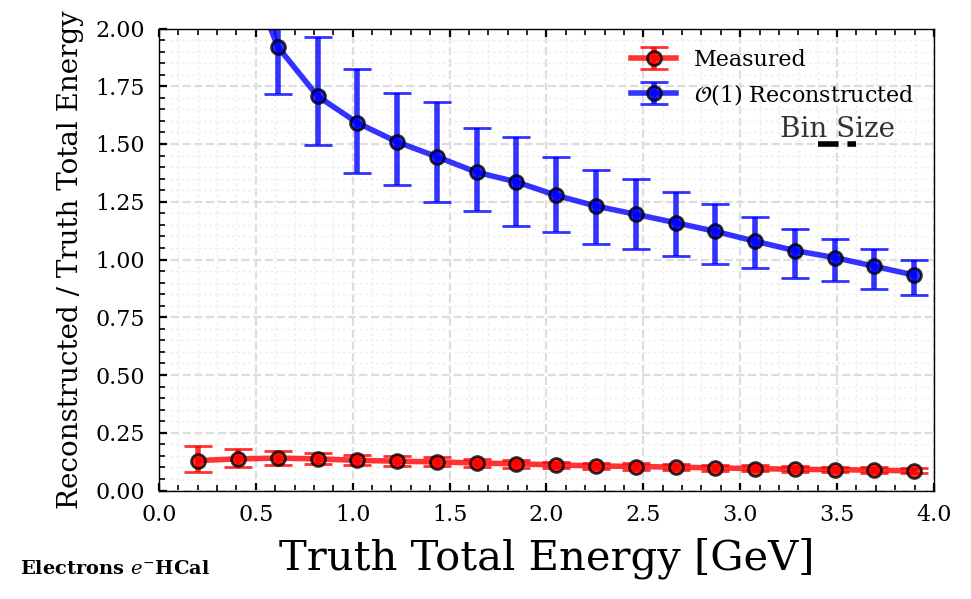

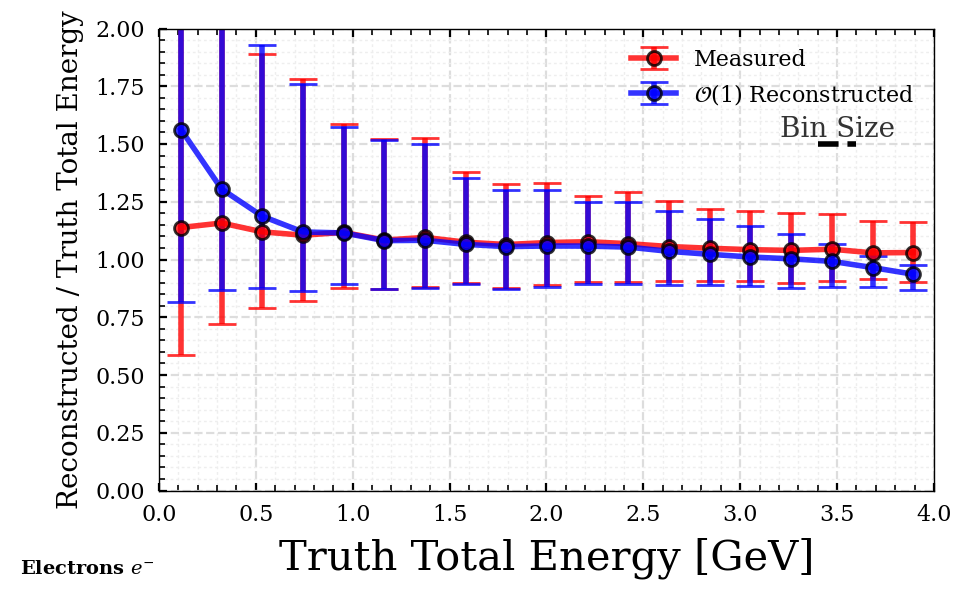

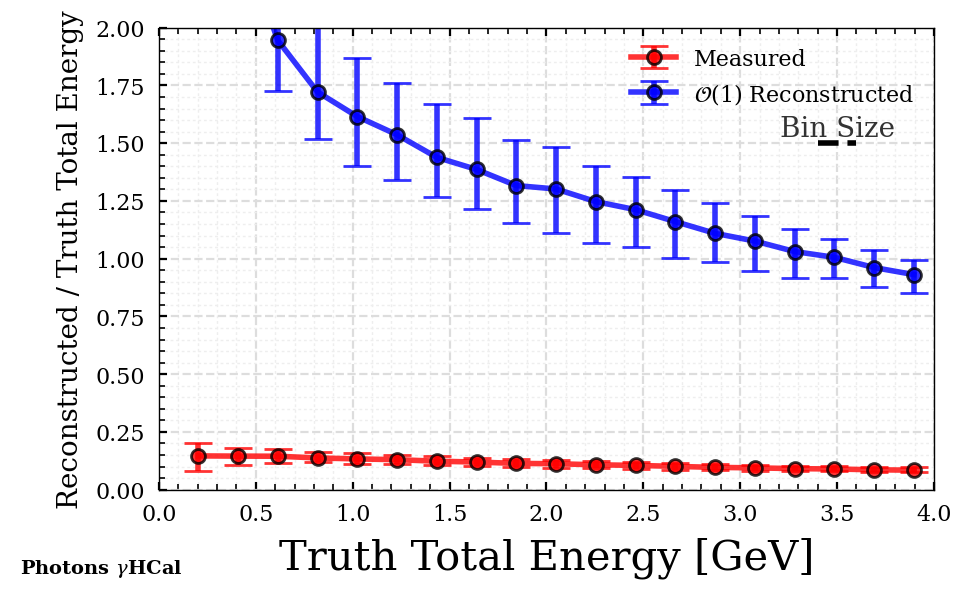

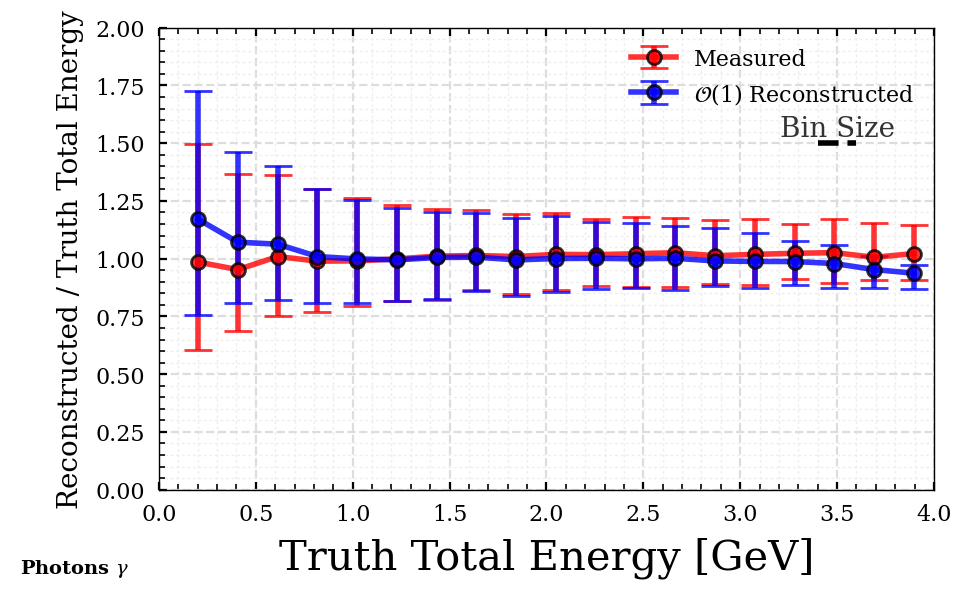

In [27]:
electrons_hcal.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
                             energy_bins_hcal=ext_bins_hcal, o1corr_hcal=avg_o1corr_hcal,
                             scheme=scheme, label=labels_dict['electron']+'HCal')
electrons.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
                        energy_bins_hcal=ext_bins_hcal, o1corr_hcal=avg_o1corr_hcal,
                        scheme=scheme, label=labels_dict['electron'])
photons_hcal.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
                           energy_bins_hcal=ext_bins_hcal, o1corr_hcal=avg_o1corr_hcal,
                           scheme=scheme, label=labels_dict['photon']+'HCal')
photons.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
                      energy_bins_hcal=ext_bins_hcal, o1corr_hcal=avg_o1corr_hcal,
                      scheme=scheme, label=labels_dict['photon'])

[1.33656018 1.33656018 1.33656018 ... 1.33656018 1.33656018 1.33656018] [11.43529746 11.55564605 11.14512338 ... 11.72433072 10.5223048
 12.7451313 ]
(9999,) (9999,)
(9999,) (9999,)
(19,) (19,) (19,)
(9999,) (9999,)
(9999,) (9999,)
(19,) (19,) (19,)
[0.99348404 0.99434521 1.04305715 ... 0.97478662 0.9144928  1.0876935 ] [25.08725659 11.58941536 39.64136513 ... 16.0534658  38.1393824
 13.00292638]
(9881,) (9881,)
(9499,) (9499,)
(19,) (19,) (19,)
(9881,) (9881,)
(9499,) (9499,)
(19,) (19,) (19,)
[1.33656018 1.33656018 1.33656018 ... 1.33656018 1.33656018 1.33656018] [11.59502405 12.65329332 13.46695438 ... 18.48201151 30.12728059
 11.99070015]
(9999,) (9999,)
(9999,) (9999,)
(19,) (19,) (19,)
(9999,) (9999,)
(9999,) (9999,)
(19,) (19,) (19,)
[1.0557366  1.03549    1.03857154 ... 1.04444015 1.02692461 1.05475556] [11.51586591 11.61460403  9.6504794  ... 12.41847618 13.17372207
 11.60516041]
(9873,) (9873,)
(9862,) (9862,)
(19,) (19,) (19,)
(9873,) (9873,)
(9862,) (9862,)
(19,) (19,) (19,

(array([ 946.43047956, 2261.61968098, 2204.01667972, ..., 1191.64780206,
         774.60368237,  399.86701687]),
 array([   8.63639176, 1105.2440384 ,  152.91744653, ...,    0.        ,
           0.        , 1977.46083888]),
 array([ 955.06687133, 3366.86371937, 2356.93412625, ..., 1191.64780206,
         774.60368237, 2377.32785575]))

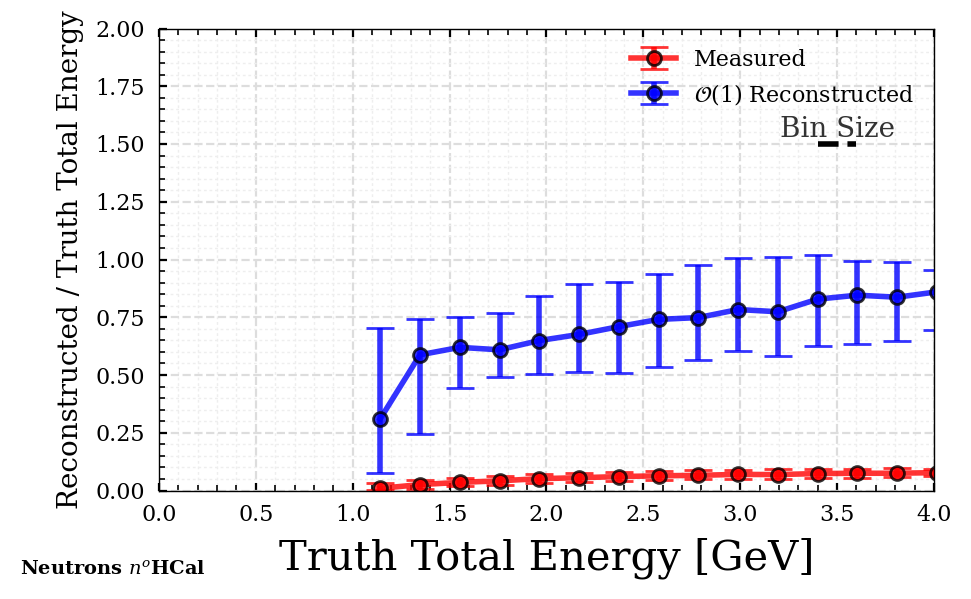

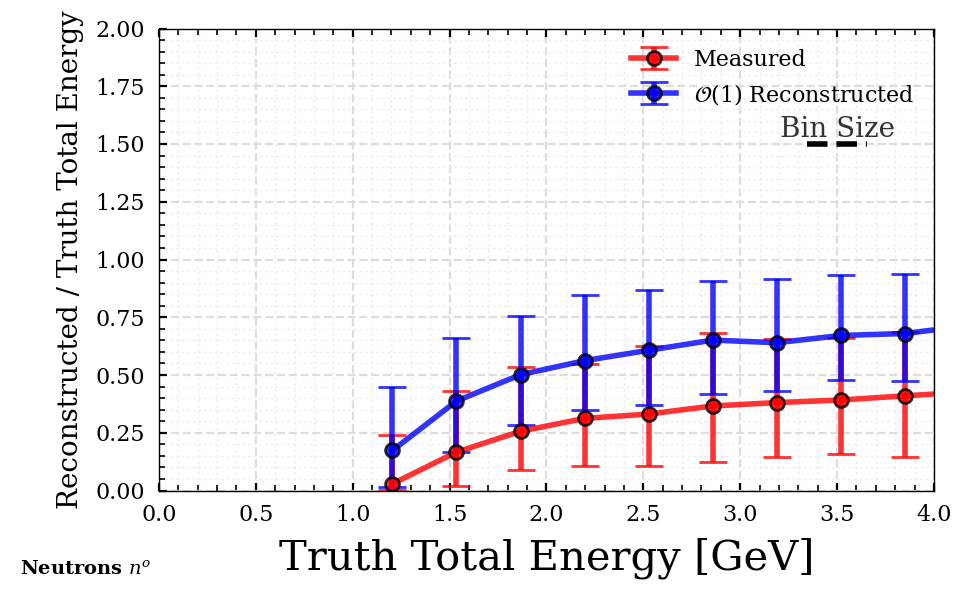

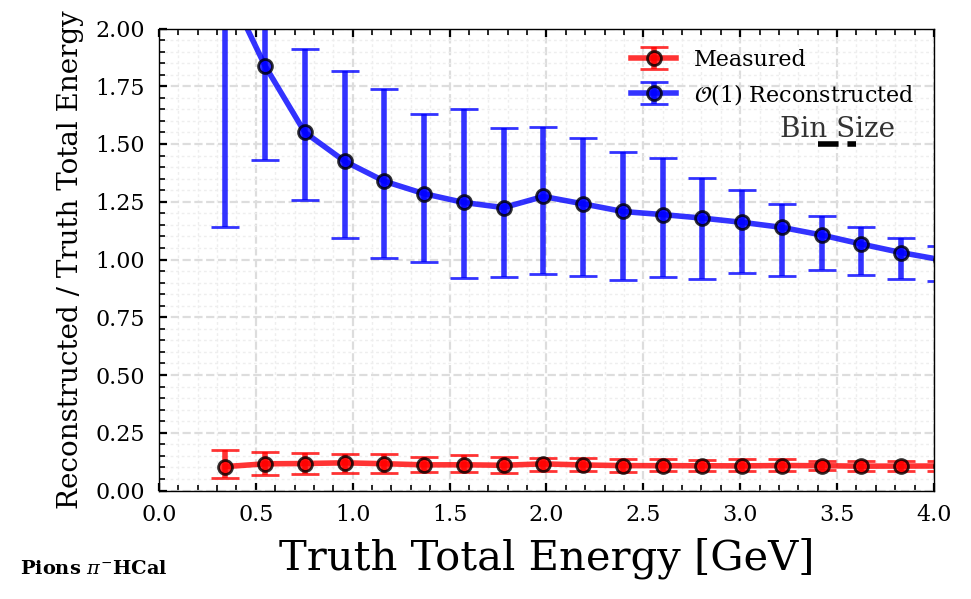

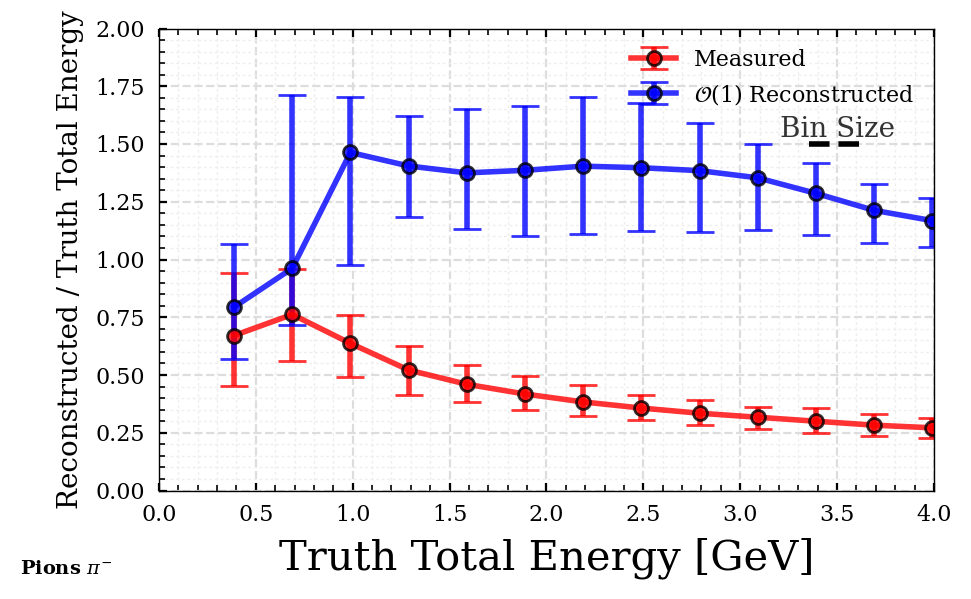

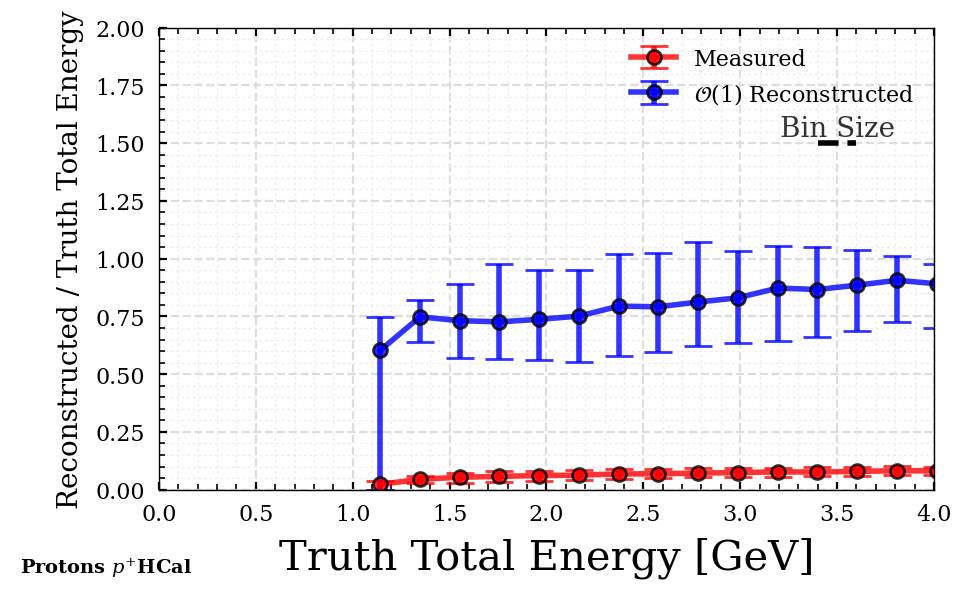

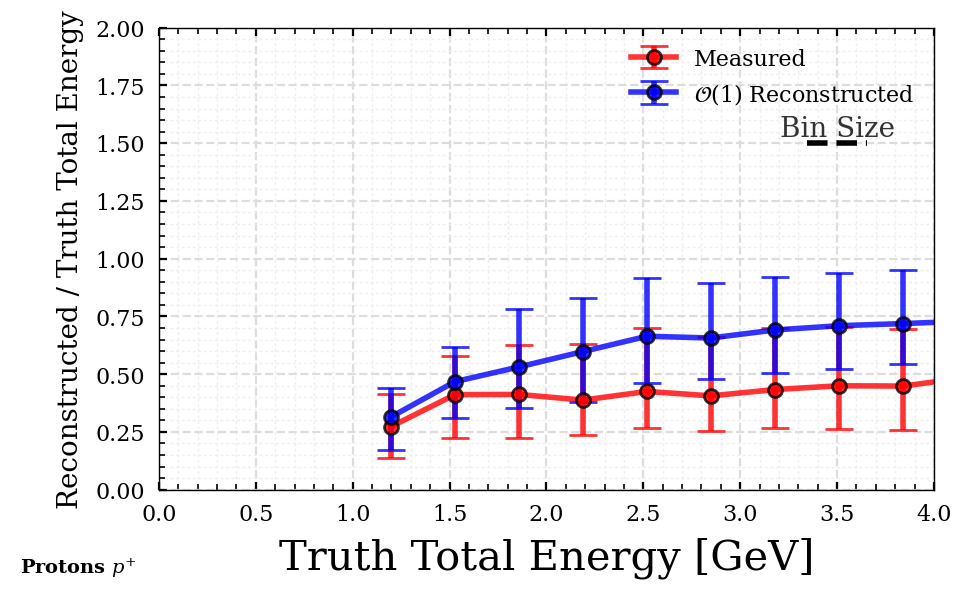

In [28]:
neutrons_hcal.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
                            energy_bins_hcal=ext_bins_hcal, o1corr_hcal=avg_o1corr_hcal,
                            scheme=scheme, label=labels_dict['neutron']+'HCal')
neutrons.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
                       energy_bins_hcal=ext_bins_hcal, o1corr_hcal=avg_o1corr_hcal,
                       scheme=scheme, label=labels_dict['neutron'])
pions_hcal.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
                         energy_bins_hcal=ext_bins_hcal, o1corr_hcal=avg_o1corr_hcal,
                         scheme=scheme, label=labels_dict['pion']+'HCal')
pions.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
                    energy_bins_hcal=ext_bins_hcal, o1corr_hcal=avg_o1corr_hcal,
                    scheme=scheme, label=labels_dict['pion'])
protons_hcal.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
                           energy_bins_hcal=ext_bins_hcal, o1corr_hcal=avg_o1corr_hcal,
                           scheme=scheme, label=labels_dict['proton']+'HCal')
protons.o1corr_energy(energy_bins_ecal=ele_energy_bins_ecal, o1corr_ecal=avg_o1corr_ecal,
                      energy_bins_hcal=ext_bins_hcal, o1corr_hcal=avg_o1corr_hcal,
                      scheme=scheme, label=labels_dict['proton'])

# Testing UVLF

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings("ignore")
from scipy import stats
from codes import jason_plotting as plotting
mpl.rcParams.update(mpl.rcParamsDefault)
plt.style.use('/Users/jasonwu/Programs/codes/def.mplstyle')
plotting.plot_prettier(dpi=400,usetex=False)
%matplotlib inline


Bad key grid.zorder in file /Users/jasonwu/Programs/codes/def.mplstyle, line 19 ('grid.zorder : 2.5')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.7.1/matplotlibrc.template
or from the matplotlib source distribution


In [ ]:
# load the m1500 dictionary
m1500_dict_c40

In [ ]:
xlim = (-25, -14)
ylim = (1e-11, 1e1)

# for C20
colors = ['maroon','peru','darkgreen','darkslateblue','indigo','black']
c40_label1 = r'$\tt GRUMPY$'
first = True

plt.figure(figsize=(6,6), dpi=300)
zrange = range(5, 11)
nbins = 25

for i, z in enumerate(zrange):
    if z == 5:
        z = 5.3
        
    bins_uncorr, phi_uncorr = \
    graph_luv_func(m1500_dict_c40[z], z=z, box_size=40/0.6814, ntrials=6,
                   nbins=nbins, color=colors[i], label=c40_label, lstyle='-', print_text=True,
                   x_label=r'$\rm {M_{1500}}$',
                   y_label=r'$10^{6-z}\Phi(\rm M_{1500})\ [\rm{Mpc}^{-3}]$',
                   xlim=xlim, ylim=ylim, lw=1.5)

    c40_label = ''
    
# bin size
textpos = [-21, 1e-1]
binsize = bins_lewis[1] - bins_lewis[0]
plt.hlines(y=textpos[1],
           xmin=(textpos[0] - binsize),
           xmax=(textpos[0]),
           color='black', lw=2, ls='-', zorder=2)
plt.text(x=textpos[0]-binsize/2, y=textpos[1]*2, s='Bin Size', fontsize=10, alpha=0.8, ha='center')

plt.legend(loc='lower right', fontsize=8)
plt.show()